# **PowerCo**

# Task 1: Business Understanding & Hypothesis Framing

PowerCo is a major gas and electricity utility that supplies to corporate, SME (Small & Medium Enterprise), and residential customers. The power-liberalization of the energy market in Europe has led to significant customer churn, especially in the SME segment. They have partnered with BCG to help diagnose the source of churning SME customers.

A fair hypothesis is that price changes affect customer churn. Therefore, it is helpful to know which customers are more (or less) likely to churn at their current price, for which a good predictive model could be useful.

Moreover, for those customers that are at risk of churning, a discount might incentivize them to stay with our client. The head of the SME division is considering a 20% discount that is considered large enough to dissuade almost anyone from churning (especially those for whom price is the primary concern).

**client_data.csv**

- id = client company identifier
- activity_new = category of the company’s activity
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months

**price_data.csv**

- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)

# Task 2: Exploratory Data Analysis

## **Sub Task 1**

Perform some exploratory data analysis. Look into the data types, data statistics, specific parameters, and variable distributions

In [1]:
#import the necessary libraries and read the datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
clients_data = pd.read_csv("client_data.csv")
price_data = pd.read_csv("price_data.csv")

In [3]:
clients_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


Let's get a description of the data types

In [4]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

We will convert the date into datetime objects

In [5]:
from datetime import datetime
# convert datetime feature to datetime data type
for f in ['date_activ','date_end','date_modif_prod','date_renewal']:
    clients_data[f] = pd.to_datetime(clients_data[f])

Let's also create two new columns for ease of access

In [6]:
clients_data['contract_start_year'] = clients_data['date_activ'].dt.year
clients_data['contract_end_year'] = clients_data['date_end'].dt.year

Let's check for missing values and duplicate records

In [7]:
# define a function to display missing values and dupliate rows
def duplicate_and_missing(dataset, dataset_name):  
    print('There are', dataset.shape[0], 'rows and', dataset.shape[1], 'columns in the dataset', '"'+dataset_name+'"','\n'+'--'*40)
    # display missing values
    if dataset.isna().sum().sum()!=0:  # if there is missing values
        missing_value = dataset.isna().sum()[dataset.isna().sum()!=0].to_frame(name='count')
        missing_value['proportion'] = missing_value['count']/len(dataset)
        print('There are', dataset.isna().sum().sum(), 'missing values')
        print(missing_value, '\n'+'--'*40)
    else:
        print('There is no missing value')
    # display duplicate rows
    if dataset.duplicated().sum()!=0:
        print('There are', dataset.duplicated().sum(), 'duplicate rows\n')
    else:
        print('There is no duplicate row\n')

In [8]:
duplicate_and_missing(dataset=clients_data, dataset_name='Client')

There are 14606 rows and 28 columns in the dataset "Client" 
--------------------------------------------------------------------------------
There is no missing value
There is no duplicate row



Let's check consistency of the feature values

In [9]:
def describe_categorical(dataset):
    cat_columns = dataset.dtypes[dataset.dtypes=='object'].index.tolist()
    if len(cat_columns)!=0:
        print('Categorical variables are', cat_columns,'\n'+'=='*40)
        for cat in cat_columns:
            describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
            describe_frame['proportion'] = describe_frame['count']/len(dataset)
            print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
    else:
        print('There is no categorical variables in the dataset')

In [10]:
describe_categorical(dataset=clients_data)

Categorical variables are ['id', 'channel_sales', 'has_gas', 'origin_up'] 
                                     id  count  proportion
0      0002203ffbb812588b632b9e628cc38d      1    0.000068
1      ab250252dfaded1c9a54834f9c829b43      1    0.000068
2      ab32c3a8d93c88b485499566526cb34d      1    0.000068
3      ab3392ec2bfd3605624f31d3c6828c21      1    0.000068
4      ab346731fef5aa291919ea43e45af5a7      1    0.000068
...                                 ...    ...         ...
14601  55091aace7bd0fadd194f46cb4886fea      1    0.000068
14602  550b8d2f9c298abd8f05fca3bc1a13c4      1    0.000068
14603  5514b18508f378a39f41657554aa72e3      1    0.000068
14604  551cb1b1faf72259c2c182dedec12c98      1    0.000068
14605  ffff7fa066f1fb305ae285bb03bf325a      1    0.000068

[14606 rows x 3 columns] 
--------------------------------------------------------------------------------
                      channel_sales  count  proportion
0  foosdfpfkusacimwkcsosbicdxkicaua   6754    0.462413

The values of "channel_sales" and "origin_up" are not understandable, so we convert these features to numeric data type by label encoding.

In [11]:
# label encoding
channel_encoder = LabelEncoder()
clients_data['channel_sales'] = channel_encoder.fit_transform(clients_data['channel_sales'])
origin_encoder = LabelEncoder()
clients_data['origin_up'] = origin_encoder.fit_transform(clients_data['origin_up'])

Now we will check for numeric features

In [12]:
# dataset: a pandas dataframe;
def describe_numeric(dataset):
    # for numeric columns whose values are discrete, display values and their frequency
    int_columns = dataset.dtypes[dataset.dtypes=='int'].index.tolist()
    # for numeric columns whose values are continuous, plot their value distribution
    float_columns = dataset.dtypes[dataset.dtypes=='float'].index.tolist()
    if len(int_columns)+len(float_columns)!=0:
        print('Numeric variables are', int_columns+float_columns,'\n'+'=='*40)
        # integer numeric feature
        if len(int_columns)!=0:    
            for cat in int_columns:
                describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
                describe_frame['proportion'] = describe_frame['count']/len(dataset)
                print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
        # 
        print(dataset[int_columns + float_columns].describe().loc[['min','max','mean','50%']].T.rename(columns={'50%':'median'}), '\n'+'--'*40)
    else:
        print('There is no numeric variables in the dataset')

In [13]:
describe_numeric(dataset=clients_data)

Numeric variables are ['channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_year', 'nb_prod_act', 'num_years_antig', 'origin_up', 'churn', 'contract_start_year', 'contract_end_year', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max'] 
   channel_sales  count  proportion
0              4   6754    0.462413
1              0   3725    0.255032
2              5   1843    0.126181
3              7   1375    0.094139
4              2    893    0.061139
5              6     11    0.000753
6              1      3    0.000205
7              3      2    0.000137 
--------------------------------------------------------------------------------
       cons_12m  count  proportion
0             0    117    0.008010
1       2882597     27    0.001849
2       3329244     24   

In [14]:
clients_data[clients_data.dtypes[clients_data.dtypes=='datetime64[ns]'].index.tolist()].describe(datetime_is_numeric=True)

,date_activ,date_end,date_modif_prod,date_renewal
count,14606,14606,14606,14606
mean,2011-01-28 07:54:18.879912448,2016-07-27 20:48:26.422018560,2013-01-02 12:29:10.951663872,2015-07-21 06:59:00.353279488
min,2003-05-09 00:00:00,2016-01-28 00:00:00,2003-05-09 00:00:00,2013-06-26 00:00:00
25%,2010-01-15 00:00:00,2016-04-27 06:00:00,2010-08-12 00:00:00,2015-04-17 00:00:00
50%,2011-03-04 00:00:00,2016-08-01 00:00:00,2013-06-19 00:00:00,2015-07-27 00:00:00
75%,2012-04-19 00:00:00,2016-10-31 00:00:00,2015-06-16 00:00:00,2015-10-29 00:00:00
max,2014-09-01 00:00:00,2017-06-13 00:00:00,2016-01-29 00:00:00,2016-01-28 00:00:00


There also seems to be no issue with the datetime features

Now, Lets observe the price dataset

In [15]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [16]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


We will also convert the date into datetime objects

In [17]:
price_data['price_date'] = pd.to_datetime(price_data['price_date'])

We will call the function defined earlier to check for missing and duplicate value

In [18]:
duplicate_and_missing(dataset=price_data, dataset_name='Client')

There are 193002 rows and 8 columns in the dataset "Client" 
--------------------------------------------------------------------------------
There is no missing value
There is no duplicate row



In [19]:
price_data['price_date'].describe(datetime_is_numeric=True)

count                           193002
mean     2015-06-16 12:50:49.933161216
min                2015-01-01 00:00:00
25%                2015-04-01 00:00:00
50%                2015-07-01 00:00:00
75%                2015-10-01 00:00:00
max                2015-12-01 00:00:00
Name: price_date, dtype: object

Let's get insights through visualizations.

In [20]:
# define a function to plot bar chart to display a feature's distribution with percent labels.
def plot_bar_chart_with_percent_label(df, target_variable, if_sort=False, gap_label_bar=0, figsize=(9,6)):
    # prepare data
    plot_data = clients_data[[target_variable]].value_counts().reset_index(name='count')
    plot_data['percent'] = plot_data['count']/plot_data['count'].sum()
    if if_sort:
        x_order = plot_data.sort_values(by=['percent'], ascending=False)[target_variable]
    else:
        x_order = plot_data.sort_values(by=[target_variable], ascending=True)[target_variable]
    # plot
    fig = plt.figure(figsize=figsize)
    ax = sns.barplot(data=plot_data, x=target_variable, y='percent', order=x_order)
    # add label
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + gap_label_bar
        ax.annotate(text='{:.2f}%'.format(p.get_height()*100), xy=(x, y), ha='center')
    ax.margins(y=0.1)

# plot stacked bar chart with percent label by churn
def plot_stacked_bar_with_percent_label_by_churn(df, target_variable, if_sort=False, figsize=(9,6)):
    plot_data = clients_data.groupby([target_variable,'churn']).size().reset_index(name='count')
    plot_data = plot_data.pivot(index=target_variable, columns='churn', values='count').fillna(0)
    plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
    if if_sort:
        plot_data = plot_data.sort_values(by=[0])
    ax = plot_data.plot(kind='bar', rot=False, stacked=True, figsize=figsize)
    plt.legend(['stay', 'switch'], loc='upper center', ncol=2)
    # add label
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height()*100)
        if percentage!='0.0%':
            x = p.get_x() + p.get_width()/2
            y = 1 - p.get_height()/1.8
            ax.annotate(text=percentage, xy=(x, y), ha='center')
    ax.margins(y=0.1)

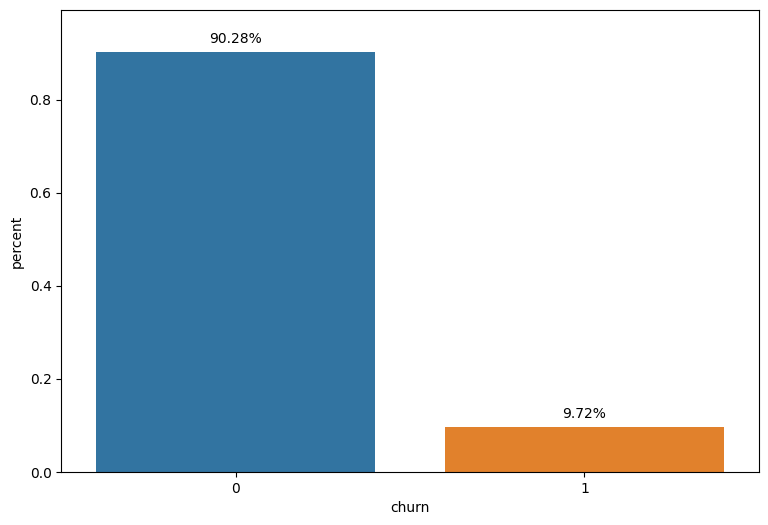

In [21]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='churn', gap_label_bar=0.02)

Only 9.72% of customers changed their providers.

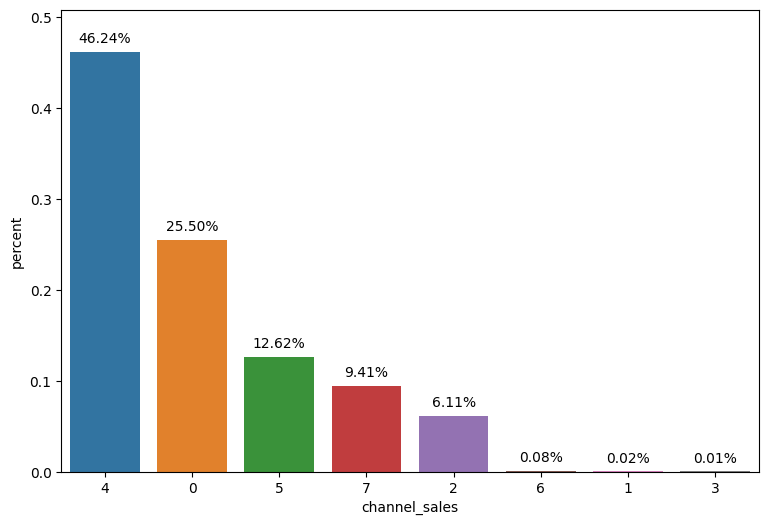

In [22]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='channel_sales', if_sort=True, gap_label_bar=0.01)

The channel with the most common sales is Type 4.

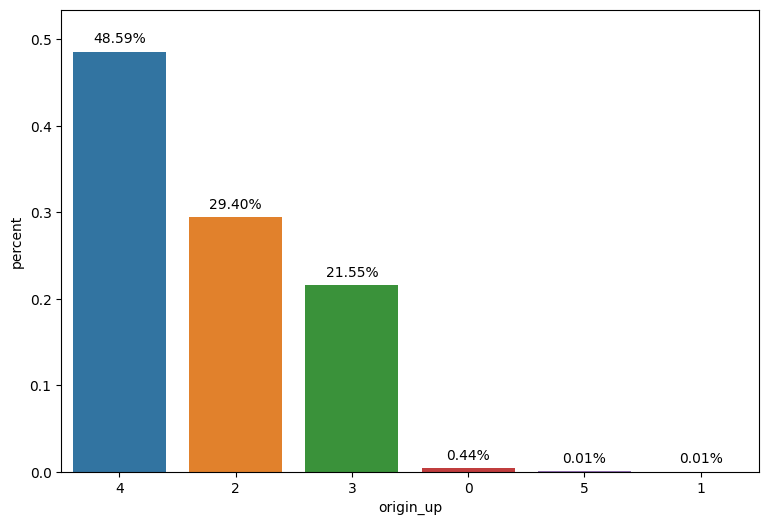

In [23]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='origin_up', if_sort=True, gap_label_bar=0.01)

Channel 4 is also the code of the electricity campaign the customer first subscribed to. Chanel 5 & 1 barely got any begining customers.

Let's Plot stacked bar charts to show the feature distribution about the churning customers and non-churning customers.

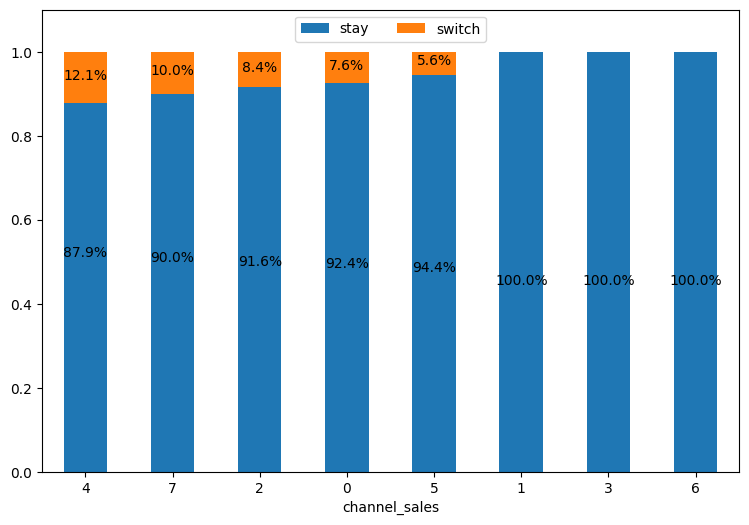

In [24]:
plot_stacked_bar_with_percent_label_by_churn(df=clients_data, target_variable='channel_sales', if_sort=True)

For the customers from different sales channels, the proportion of churning customers ranges from 5.6% to 12.1% (excluding rare channels).

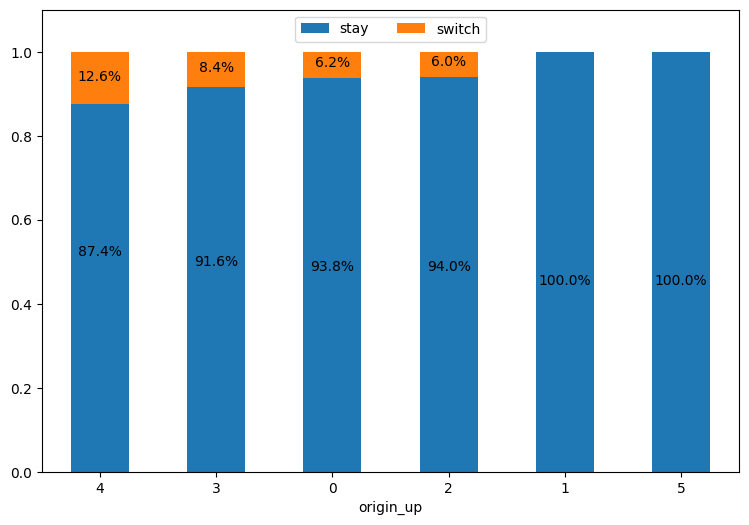

In [25]:
plot_stacked_bar_with_percent_label_by_churn(df=clients_data, target_variable='origin_up', if_sort=True)

For the customers who first subscribed to different electricity campaigns, the proportion of churning customers ranges from 6.0% to 12.6% (excluding type 1 and type 5).

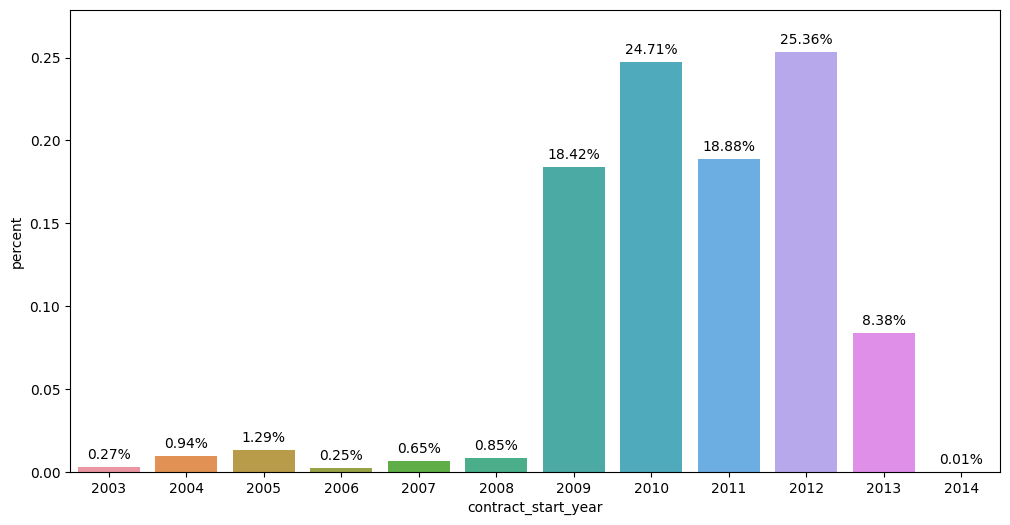

In [26]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='contract_start_year', if_sort=False, gap_label_bar=0.005, figsize=(12,6))

Most cutomers started their contracts from 2009 to 2013. Among these cutomers, it seems newer customers are more likely to switch to other providers.

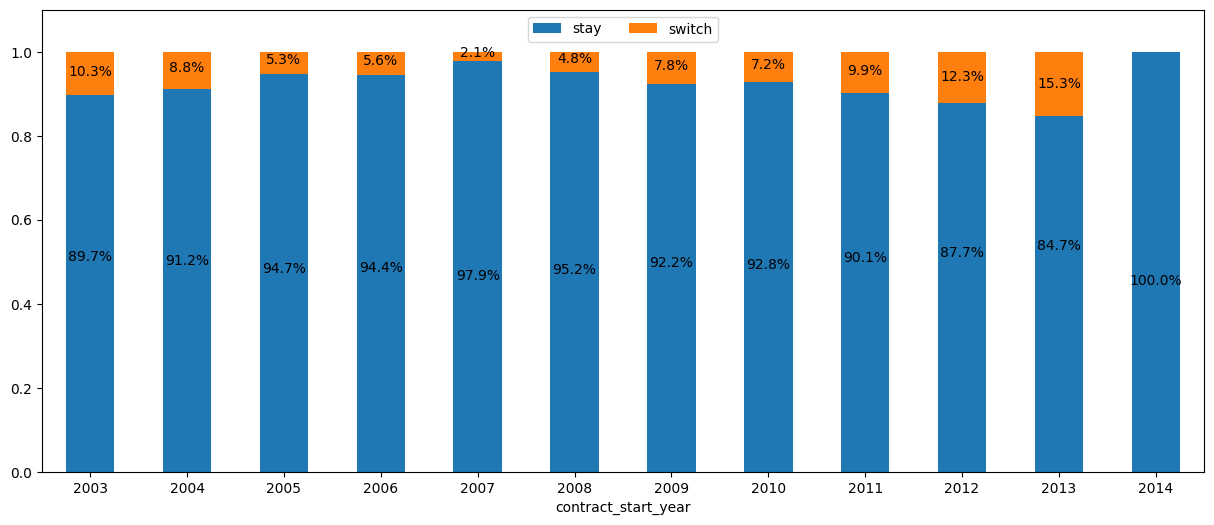

In [27]:
plot_stacked_bar_with_percent_label_by_churn(df=clients_data, target_variable='contract_start_year', if_sort=False, figsize=(15,6))

Most cutomers stayed with the current providers. Among these customers, it seems newer customers are more likely to switch to other providers.

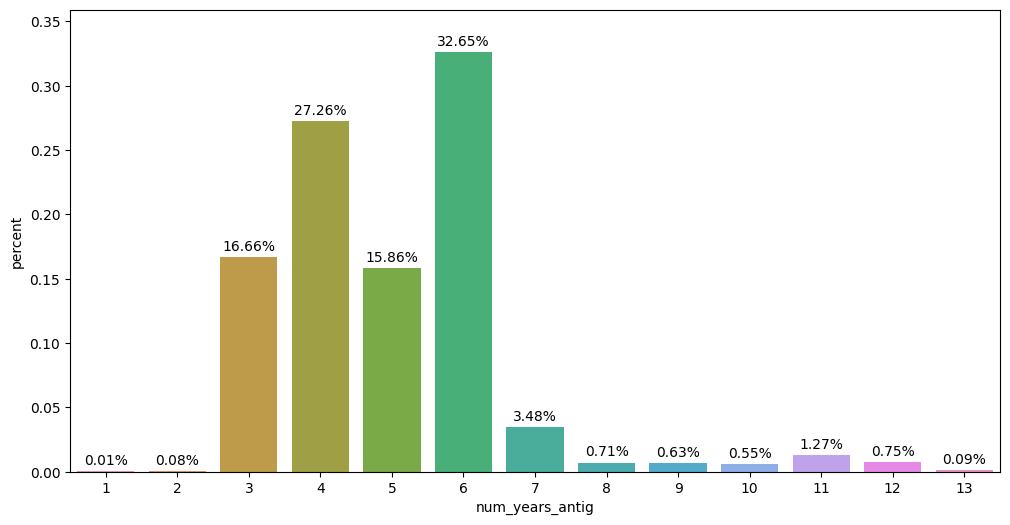

In [28]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='num_years_antig', if_sort=False, gap_label_bar=0.005, figsize=(12,6))

Most customers have spent 6 years with their current provider.

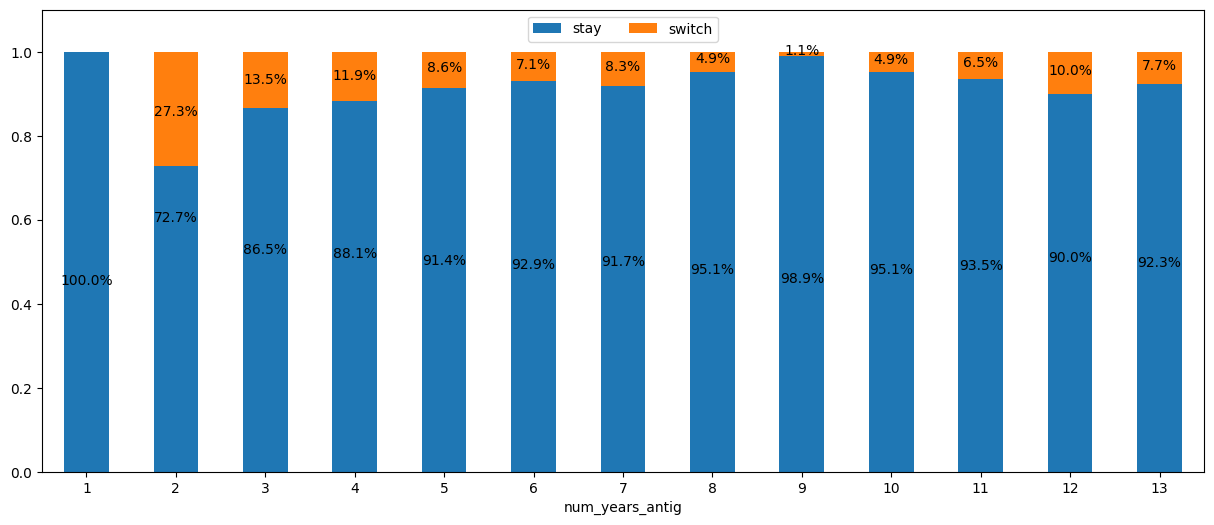

In [29]:
plot_stacked_bar_with_percent_label_by_churn(df=clients_data, target_variable='num_years_antig', if_sort=False, figsize=(15,6))

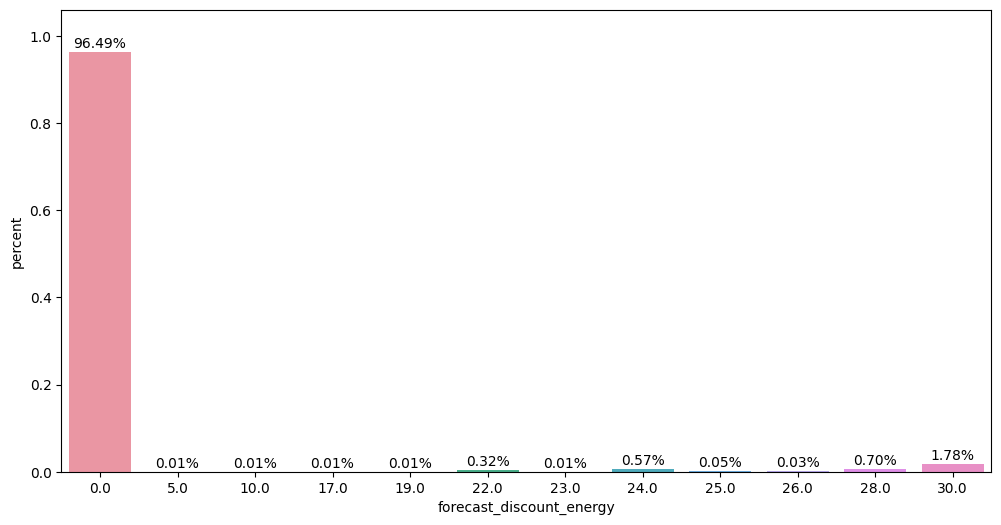

In [30]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='forecast_discount_energy', if_sort=False, gap_label_bar=0.01, figsize=(12,6))

The vast majority of cutomers' forecasted value of current discount is 0.

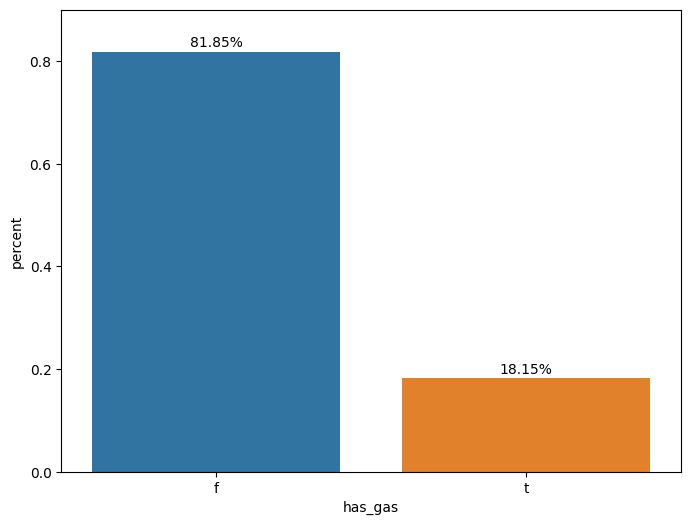

In [31]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='has_gas', if_sort=False, gap_label_bar=0.01, figsize=(8,6))

Only about 18% of the customers were also gas clients.

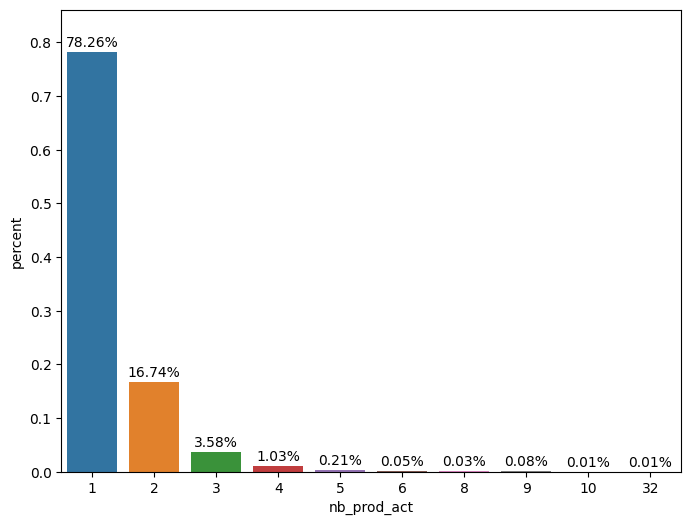

In [32]:
plot_bar_chart_with_percent_label(df=clients_data, target_variable='nb_prod_act', if_sort=False, gap_label_bar=0.01, figsize=(8,6))

78% of customers only have 1 active products and services subcribed to

Let's Plot histograms the distribution of continous numeric features.

In [33]:
# plot histogram
def plot_histogram_by_churn(df, target_variable, figsize=(20,5), bins=100, if_churn=True):
    fig = plt.figure(figsize=figsize)
    if if_churn:
        ax = sns.histplot(data=df, x=target_variable, bins=bins, hue='churn')
    else:
        ax = sns.histplot(data=df, x=target_variable, bins=bins)

In [34]:
price_data['id'].value_counts().value_counts()

12    15990
11       83
10       11
9         6
8         3
7         3
Name: id, dtype: int64

In [35]:
price_data['price_date'].value_counts()

2015-08-01    16094
2015-12-01    16094
2015-07-01    16090
2015-11-01    16087
2015-06-01    16085
2015-10-01    16085
2015-02-01    16082
2015-09-01    16082
2015-05-01    16080
2015-04-01    16079
2015-03-01    16074
2015-01-01    16070
Name: price_date, dtype: int64

## **Sub Task 2**

Now, let's check customers sensitivity to price. (Note: Normally, assuming other factors do not change, when the price increases and some cutomers switch, then we can say these customers are sensitive to price as the increase in prices lead the customer churn. But, if there is a decrease or no change in the price and cutomers still change their proveiders, I think in this case we cannot say these cutomers are sensitive to price.)

We will calculate maximum, minimum and average prices over the whole year.

In [36]:
stat_ = ['max', 'min', 'mean']
price_attr = ['price_off_peak_var','price_peak_var','price_mid_peak_var','price_off_peak_fix','price_peak_fix','price_mid_peak_fix']
price_stat = price_data.drop(columns=['price_date']).groupby(['id']).agg({'price_off_peak_var': stat_, 'price_peak_var': stat_, 'price_mid_peak_var': stat_,
                                                      'price_off_peak_fix': stat_, 'price_peak_fix': stat_, 'price_mid_peak_fix': stat_,})
# flatten the column names
price_stat.columns = ['_'.join(x) for x in zip(price_stat.columns.get_level_values(0), price_stat.columns.get_level_values(1))]
price_stat = price_stat.reset_index()
price_stat.head(3)

,id,price_off_peak_var_max,price_off_peak_var_min,price_off_peak_var_mean,price_peak_var_max,price_peak_var_min,price_peak_var_mean,price_mid_peak_var_max,price_mid_peak_var_min,price_mid_peak_var_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean
0,0002203ffbb812588b632b9e628cc38d,0.128067,0.119906,0.124338,0.105842,0.101673,0.103794,0.073773,0.070232,0.07316,40.728885,40.565969,40.701732,24.43733,24.339581,24.421038,16.291555,16.226389,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.143943,0.146426,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44.444710,44.266931,44.385450,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.150837,0.181558,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,45.944710,44.444710,45.319710,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


We merge client dataset to the above dataset to add churn data

In [37]:
# add churn values
price_stat = price_stat.merge(clients_data[['id','churn']], on=['id'], how='left')
# drop ids that are not inclued in the price dataset 
price_stat = price_stat.dropna(subset=['churn']).reset_index(drop=True)
price_stat.head(3)

,id,price_off_peak_var_max,price_off_peak_var_min,price_off_peak_var_mean,price_peak_var_max,price_peak_var_min,price_peak_var_mean,price_mid_peak_var_max,price_mid_peak_var_min,price_mid_peak_var_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean,churn
0,0002203ffbb812588b632b9e628cc38d,0.128067,0.119906,0.124338,0.105842,0.101673,0.103794,0.073773,0.070232,0.07316,40.728885,40.565969,40.701732,24.43733,24.339581,24.421038,16.291555,16.226389,16.280694,0.0
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.143943,0.146426,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44.444710,44.266931,44.385450,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.150837,0.181558,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,45.944710,44.444710,45.319710,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Now let's calculate the biggest changes in prices over the whole year.

In [38]:
# add diff
for attr in price_attr:
    price_stat[f'diff_Dec_mean_{attr}'] = price_data[price_data['id'].isin(price_stat['id'])].groupby(['id'])[attr].nth(-1).values - price_stat[f'{attr}_mean']
#
price_stat.head(3)

,id,price_off_peak_var_max,price_off_peak_var_min,price_off_peak_var_mean,price_peak_var_max,price_peak_var_min,price_peak_var_mean,price_mid_peak_var_max,price_mid_peak_var_min,price_mid_peak_var_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_off_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,price_mid_peak_fix_mean,churn,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.128067,0.119906,0.124338,0.105842,0.101673,0.103794,0.073773,0.070232,0.07316,40.728885,40.565969,40.701732,24.43733,24.339581,24.421038,16.291555,16.226389,16.280694,0.0,-0.004432,-0.002121,0.000559,0.027153,0.016292,0.010861
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.143943,0.146426,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44.444710,44.266931,44.385450,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.002483,0.000000,0.000000,0.059260,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.150837,0.181558,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,45.944710,44.444710,45.319710,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.019722,0.000000,0.000000,0.625000,0.000000,0.000000


Most cutomers' prices did not change much and kept stable.

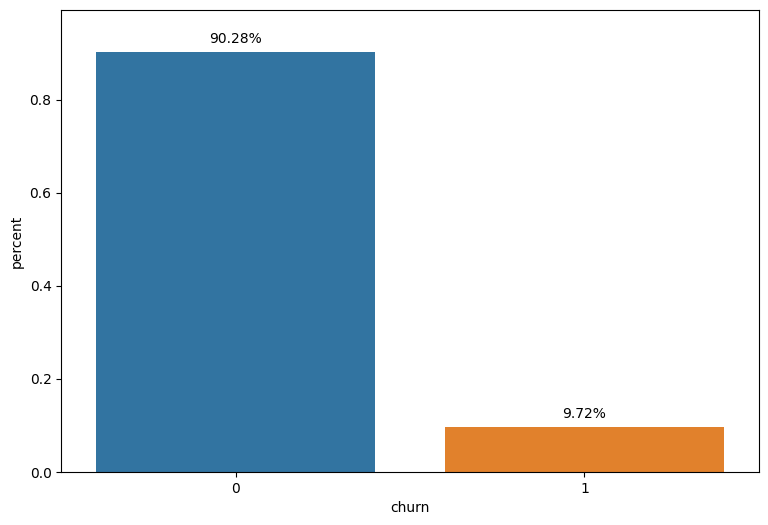

In [39]:
plot_bar_chart_with_percent_label(df=price_stat[price_stat['diff_Dec_mean_price_off_peak_var']>0], target_variable='churn', gap_label_bar=0.02)

Among the cutomers whose off-peak enery prices increased, around 9.72% of customers changed their providers.

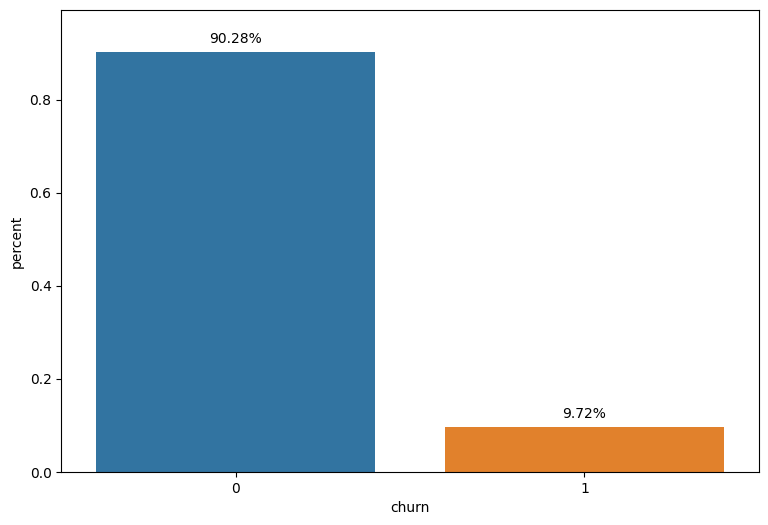

In [40]:
plot_bar_chart_with_percent_label(df=price_stat[price_stat['diff_Dec_mean_price_off_peak_var']<=0], target_variable='churn', gap_label_bar=0.02)

Among the cutomers whose off-peak energy prices did not increase (decreased or did not change), also around 9.72% of customers changed their providers.

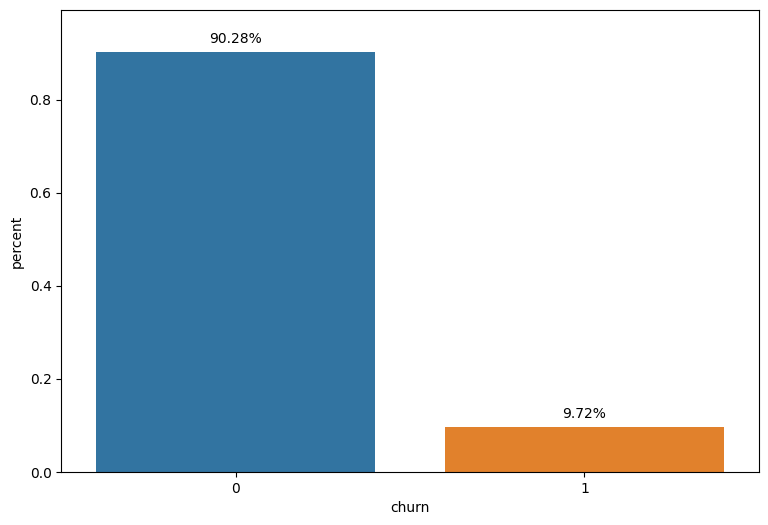

In [41]:
plot_bar_chart_with_percent_label(df=price_stat[price_stat['diff_Dec_mean_price_off_peak_fix']<=0], target_variable='churn', gap_label_bar=0.02)

Among the cutomers whose off-peak power prices increased, around 9.72% of customers changed their providers.

**From the above results, we can see no matter how prices changed, proportion of churning customers always stayed around 9.72%. In other words, changes in prices did not affect customer churn. Therefore, we can conclude customers were not sensitive to prices.**

# Task 3: Feature Engineering and Modeling

## Sub Task 3

In [42]:
train_data = clients_data.copy()
train_data['year_modif_prod'] = train_data['date_modif_prod'].dt.year
train_data['year_renewal'] = train_data['date_renewal'].dt.year
train_data = train_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])
# 
has_gas_encoder = LabelEncoder()
train_data['has_gas'] = has_gas_encoder.fit_transform(train_data['has_gas'])
# add new feature "diff_dec_jan_off_peak_var" and "diff_dec_jan_off_peak_fix". I just calculate the differnece between last price and first price for each customer.
diff_dec_jan_off_peak_var = price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(-1) - price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(0)
diff_dec_jan_off_peak_var = diff_dec_jan_off_peak_var.reset_index(name='diff_dec_jan_off_peak_var')
diff_dec_jan_off_peak_fix = price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(-1) - price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(0)
diff_dec_jan_off_peak_fix = diff_dec_jan_off_peak_fix.reset_index(name='diff_dec_jan_off_peak_fix')
train_data = train_data.merge(diff_dec_jan_off_peak_var, on='id', how='left')
train_data = train_data.merge(diff_dec_jan_off_peak_fix, on='id', how='left')
# also add the above differences of other prices
for attr in ['price_peak_var','price_peak_fix','price_mid_peak_var','price_mid_peak_fix']:
    diff_dec_jan_temp = price_data.sort_values(by=['price_date']).groupby(['id'])[attr].nth(-1) - price_data.sort_values(by=['price_date']).groupby(['id'])[attr].nth(0)
    diff_dec_jan_temp = diff_dec_jan_temp.reset_index(name=f'diff_dec_jan_{attr}')
    train_data = train_data.merge(diff_dec_jan_temp, on='id', how='left')
# add price changing trends
train_data = train_data.merge(price_stat[['id','diff_Dec_mean_price_off_peak_var','diff_Dec_mean_price_off_peak_fix',
                                          'diff_Dec_mean_price_peak_var','diff_Dec_mean_price_peak_fix',
                                          'diff_Dec_mean_price_mid_peak_var','diff_Dec_mean_price_mid_peak_fix',
                                        ]], on='id', how='left')

#
train_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,year_modif_prod,year_renewal,diff_dec_jan_off_peak_var,diff_dec_jan_off_peak_fix,diff_dec_jan_price_peak_var,diff_dec_jan_price_peak_fix,diff_dec_jan_price_mid_peak_var,diff_dec_jan_price_mid_peak_fix,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,2015,2015,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389,0.021246,3.324664,-0.015266,-22.352010,-0.066530,-14.901340
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,2009,2015,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000,-0.002009,0.133335,-0.007124,0.000000,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,2010,2015,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000,-0.002714,0.059260,-0.000012,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,2010,2015,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000,-0.002624,0.044445,0.000000,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,2010,2015,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166,-0.004268,0.040729,-0.001965,0.024437,0.000854,0.016292


Create training data and training label.

Note: for tree-based models

- There is no need to perform data scaling, unlike other machine learning models.
- Do not apply one-hot encoding to processing categorical variables, just use label-encoding to convert categorical variables to numeric variables.

In [43]:
X = train_data.drop(columns=['id','churn'])
y = train_data['churn']
X.shape, y.shape

((14606, 36), (14606,))

## Sub Task 4

According to the task requirement, build a RandomForest model.

As there is no testing set, the "out-of-fold" cross validation strategy is used to evaluate the model's performace. Besides, the training set is a very imbalanced dataset, so I use precision and recall as the metrics, instead of accuracy (results of accuracy are still shown, but not for evaluating the model's performance). As the goal of this task is not to find the optimal parameters, I do not tune the model's parameters.

In [44]:
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
feature_importance_df = pd.DataFrame(data={'feature_name':X.columns, 'feature_importance':[0]*len(X.columns)})
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    feature_importance_df['feature_importance'] = feature_importance_df['feature_importance'] + (rf.feature_importances_)
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
# predicted labels
pred_y = pred_train_labels.argmax(axis=-1)
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.714 Recall 0.053 Accuracy 0.906
Fold 2 Precision 0.885 Recall 0.081 Accuracy 0.910
Fold 3 Precision 0.895 Recall 0.060 Accuracy 0.908
Fold 4 Precision 0.944 Recall 0.060 Accuracy 0.908
Fold 5 Precision 0.850 Recall 0.060 Accuracy 0.908
Total  Precision 0.856 Recall 0.063 Accuracy 0.908


The figure below shows the importance of each features.

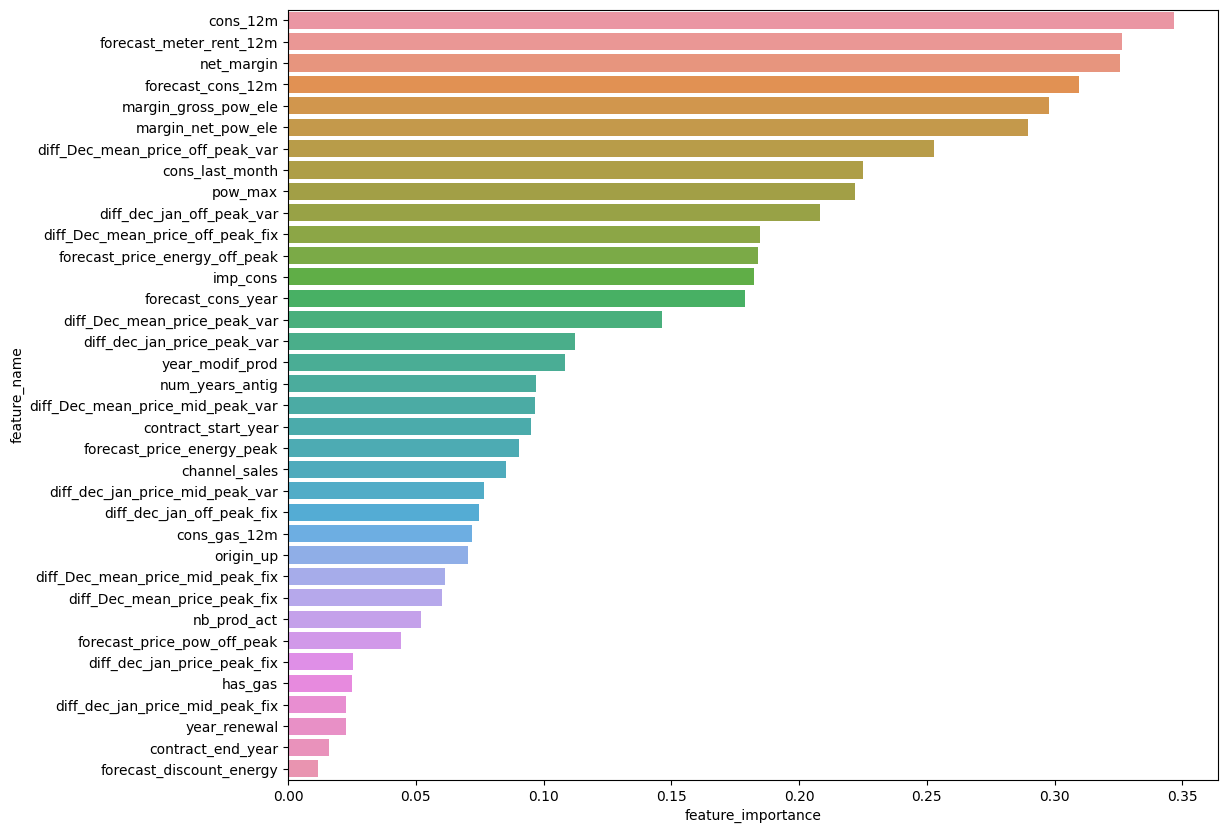

In [45]:
fig = plt.figure(figsize=(12,10))
ax = sns.barplot(data=feature_importance_df.sort_values(by=['feature_importance'], ascending=False), y='feature_name', x='feature_importance')

The table below shows the main classification metric.

In [46]:
print(classification_report(y, pred_y))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13187
           1       0.86      0.06      0.12      1419

    accuracy                           0.91     14606
   macro avg       0.88      0.53      0.53     14606
weighted avg       0.90      0.91      0.87     14606



A confusion matrix

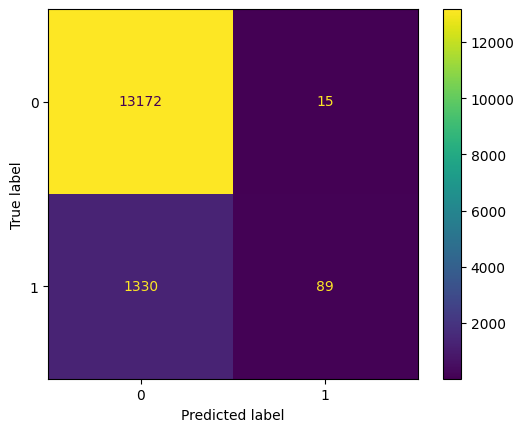

In [47]:
cm = confusion_matrix(y, pred_y, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

Based on the results above, we can see the performance is very bad. Although the accuracy is up to 90%, it is misleading and pointless, as we only focus on correctly predicting the positive class rather than the nagetive class. The model can only find out 6% of real positive samples. But luckily, in the predicted positive samples, up to 86% of them are real positive samples

## Bonus task: Identify the impact of a 20% discount

- Firstly, intuitively, we have concluded that changes in prices do not have a significant impact on customer churn. So, a discount should be unable to prevent customer churn.
- Secondly, we cannot really identify whether a discount can prevent customer churn, as we do not exactly know what will happen in the future.
Therefore, I try to calculate the expected profit based on the probability of customer churn evaluate the impact of the discount.

In [48]:
prob_no_discount = pd.DataFrame(data = pred_train_labels, columns=['0', '1'])
prob_no_discount['id'] = train_data['id']
prob_no_discount = prob_no_discount[['id','0','1']]
prob_no_discount

,id,0,1
0,24011ae4ebbe3035111d65fa7c15bc57,0.66,0.34
1,d29c2c54acc38ff3c0614d0a653813dd,0.95,0.05
2,764c75f661154dac3a6c254cd082ea7d,0.89,0.11
3,bba03439a292a1e166f80264c16191cb,0.84,0.16
4,149d57cf92fc41cf94415803a877cb4b,0.99,0.01
...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.90,0.10
14602,d0a6f71671571ed83b2645d23af6de00,0.41,0.59
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.86,0.14
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.93,0.07


We need to predcit the probability of churn when applying a 20% discount

In [49]:
# drop useless columns
test_data = clients_data.copy()
test_data['year_modif_prod'] = test_data['date_modif_prod'].dt.year
test_data['year_renewal'] = test_data['date_renewal'].dt.year
test_data = test_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])
# 
has_gas_encoder = LabelEncoder()
test_data['has_gas'] = has_gas_encoder.fit_transform(test_data['has_gas'])
# apply a 20% discount
diff_dec_jan_off_peak_var = price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(-1)*0.8 - price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(0)*0.8
diff_dec_jan_off_peak_var = diff_dec_jan_off_peak_var.reset_index(name='diff_dec_jan_off_peak_var')
diff_dec_jan_off_peak_fix = price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(-1)*0.8 - price_data.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(0)*0.8
diff_dec_jan_off_peak_fix = diff_dec_jan_off_peak_fix.reset_index(name='diff_dec_jan_off_peak_fix')
test_data = test_data.merge(diff_dec_jan_off_peak_var, on='id', how='left')
test_data = test_data.merge(diff_dec_jan_off_peak_fix, on='id', how='left')
# also add the above differences of other prices
for attr in ['price_peak_var','price_peak_fix','price_mid_peak_var','price_mid_peak_fix']:
    diff_dec_jan_temp = price_data.sort_values(by=['price_date']).groupby(['id'])[attr].nth(-1)*0.8 - price_data.sort_values(by=['price_date']).groupby(['id'])[attr].nth(0)*0.8
    diff_dec_jan_temp = diff_dec_jan_temp.reset_index(name=f'diff_dec_jan_{attr}')
    test_data = test_data.merge(diff_dec_jan_temp, on='id', how='left')
# add price changing trends
price_attr = ['price_off_peak_var','price_peak_var','price_mid_peak_var','price_off_peak_fix','price_peak_fix','price_mid_peak_fix']
price_stat_test = price_data.drop(columns=['price_date']).groupby(['id']).agg({'price_off_peak_var': ['mean'], 'price_peak_var': ['mean'], 'price_mid_peak_var': ['mean'],
                                                      'price_off_peak_fix': ['mean'], 'price_peak_fix': ['mean'], 'price_mid_peak_fix': ['mean'],})
# flatten the column names
price_stat_test.columns = ['_'.join(x) for x in zip(price_stat_test.columns.get_level_values(0), price_stat_test.columns.get_level_values(1))]
price_stat_test = price_stat_test.reset_index()
# add diff
for attr in price_attr:
    price_stat_test[f'diff_Dec_mean_{attr}'] = price_data[price_data['id'].isin(price_stat_test['id'])].groupby(['id'])[attr].nth(-1).values*0.8 - price_stat_test[f'{attr}_mean']*0.8
#
test_data = test_data.merge(price_stat_test[['id','diff_Dec_mean_price_off_peak_var','diff_Dec_mean_price_off_peak_fix',
                                          'diff_Dec_mean_price_peak_var','diff_Dec_mean_price_peak_fix',
                                          'diff_Dec_mean_price_mid_peak_var','diff_Dec_mean_price_mid_peak_fix',
                                        ]], on='id', how='left')

#
test_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,year_modif_prod,year_renewal,diff_dec_jan_off_peak_var,diff_dec_jan_off_peak_fix,diff_dec_jan_price_peak_var,diff_dec_jan_price_peak_fix,diff_dec_jan_price_mid_peak_var,diff_dec_jan_price_mid_peak_fix,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,2015,2015,0.016046,2.960768,-0.014330,-19.471665,-0.057229,-12.981111,0.016997,2.659732,-0.012213,-17.881608,-0.053224,-11.921072
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,2009,2015,-0.003014,0.142223,0.000000,0.000000,0.000000,0.000000,-0.001607,0.106668,-0.005699,0.000000,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,2010,2015,-0.003736,0.142223,0.000422,0.000000,0.000000,0.000000,-0.002171,0.047408,-0.000010,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,2010,2015,-0.003638,0.142223,0.000000,0.000000,0.000000,0.000000,-0.002099,0.035556,0.000000,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,2010,2015,-0.004954,0.130332,-0.001842,0.078199,0.002790,0.052133,-0.003415,0.032583,-0.001572,0.019550,0.000683,0.013033


In [50]:
#
testing_set = test_data.drop(columns=['id','churn'])
testing_set.shape

(14606, 36)

In [51]:
# 
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
pred_test_labels = np.zeros(shape=(testing_set.shape[0], 2))
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    pred_test_labels += rf.predict_proba(testing_set)/5
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
# 
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.714 Recall 0.053 Accuracy 0.906
Fold 2 Precision 0.885 Recall 0.081 Accuracy 0.910
Fold 3 Precision 0.895 Recall 0.060 Accuracy 0.908
Fold 4 Precision 0.944 Recall 0.060 Accuracy 0.908
Fold 5 Precision 0.850 Recall 0.060 Accuracy 0.908
Total  Precision 0.856 Recall 0.063 Accuracy 0.908


Now, combine all results into a single dataset.

In [52]:
#
prob_discount = pd.DataFrame(data=pred_test_labels, columns=['0_dis','1_dis'])
customer_prob = prob_no_discount.join(prob_discount)
customer_prob.head()

,id,0,1,0_dis,1_dis
0,24011ae4ebbe3035111d65fa7c15bc57,0.66,0.34,0.422,0.578
1,d29c2c54acc38ff3c0614d0a653813dd,0.95,0.05,0.948,0.052
2,764c75f661154dac3a6c254cd082ea7d,0.89,0.11,0.888,0.112
3,bba03439a292a1e166f80264c16191cb,0.84,0.16,0.936,0.064
4,149d57cf92fc41cf94415803a877cb4b,0.99,0.01,0.970,0.030


Then, let's calculate the expected profit from customers.

In [53]:
#calculate expected profit of a single customer with discounted prices and without discounted prices
def expect_from_a_customer(customer_id):
    # expected values without discount
    average_yearly_price_var = price_stat[price_stat['id']==customer_id]['price_off_peak_var_mean'].values[0]
    total_yearly_usage_var = clients_data[clients_data['id']==customer_id]['cons_12m'].values[0]
    average_yearly_price_fix = price_stat[price_stat['id']==customer_id]['price_off_peak_fix_mean'].values[0]
    total_yearly_usage_fix = clients_data[clients_data['id']==customer_id]['cons_gas_12m'].values[0]
    total_profit = average_yearly_price_var*total_yearly_usage_var + average_yearly_price_fix*total_yearly_usage_fix
    # 
    prob_stay = customer_prob[customer_prob['id']==customer_id]['0'].values[0]
    expected_profit = prob_stay*total_profit
    # expected values with discount
    total_profit_dis = total_profit*0.8
    # 
    prob_stay_dis = customer_prob[customer_prob['id']==customer_id]['0_dis'].values[0]
    expected_profit_dis = prob_stay_dis*total_profit_dis
    return expected_profit, expected_profit_dis

In [54]:
# Calculate expected profit from each customer
expected_no_dis, expected_dis = [],[]
for cus_id in customer_prob['id']:
    temp = expect_from_a_customer(customer_id=cus_id)
    expected_no_dis.append(temp[0])
    expected_dis.append(temp[1])
#
customer_prob['expected_no_dis'] = expected_no_dis
customer_prob['expected_dis'] = expected_dis
customer_prob['diff_discount'] = customer_prob['expected_dis'] - customer_prob['expected_no_dis']
customer_prob

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
0,24011ae4ebbe3035111d65fa7c15bc57,0.66,0.34,0.422,0.578,1.484745e+06,7.594696e+05,-725275.463026
1,d29c2c54acc38ff3c0614d0a653813dd,0.95,0.05,0.948,0.052,6.623187e+02,5.287395e+02,-133.579219
2,764c75f661154dac3a6c254cd082ea7d,0.89,0.11,0.888,0.112,8.255493e+01,6.589553e+01,-16.659399
3,bba03439a292a1e166f80264c16191cb,0.84,0.16,0.936,0.064,2.011941e+02,1.793502e+02,-21.843930
4,149d57cf92fc41cf94415803a877cb4b,0.99,0.01,0.970,0.030,5.439767e+02,4.263898e+02,-117.586885
...,...,...,...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.90,0.10,0.936,0.064,1.918601e+06,1.596276e+06,-322325.008098
14602,d0a6f71671571ed83b2645d23af6de00,0.41,0.59,0.386,0.614,3.162780e+02,2.382113e+02,-78.066670
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.86,0.14,0.596,0.404,1.971808e+02,1.093207e+02,-87.860111
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.93,0.07,0.932,0.068,1.822685e+01,1.461284e+01,-3.614013


Expected profit from only 349 customers (2%) rise after being offered discounted prices.

In [55]:
customer_prob[customer_prob['diff_discount']>0]

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
128,3c4ee938001975a4d07cf27a54de433c,0.67,0.33,0.888,0.112,3254.731758,3450.987225,196.255467
139,cf8c5db0c02e3f92592daccba41c918c,0.60,0.40,0.782,0.218,501505.138799,522902.691387,21397.552589
217,b1e773762052b38569b1e68aaa10576e,0.39,0.61,0.576,0.424,2692.006048,3180.708684,488.702636
230,9ca6298400dbc960a48a46aa6abd3db7,0.25,0.75,0.354,0.646,2565.754701,2906.486925,340.732224
346,395a6f41bbd1a0f23a64f00645264e78,0.64,0.36,0.818,0.182,4439.209887,4539.092109,99.882222
...,...,...,...,...,...,...,...,...
14384,87ec37604794b702c77225967c20f476,0.64,0.36,0.864,0.136,215.637276,232.888258,17.250982
14536,acfb0c97e40a86087f185d4846217966,0.68,0.32,0.862,0.138,213950.664602,216971.144572,3020.479971
14537,d77e823d24aa59beda5baa6bca37c903,0.63,0.37,0.846,0.154,264.275878,283.907801,19.631922
14561,37f06f14bb662b84f4f464322dce72db,0.68,0.32,0.878,0.122,1118.446236,1155.289171,36.842935


In [56]:
# 2% of all cutomers
customer_prob[customer_prob['diff_discount']>0].shape[0]/len(customer_prob)

0.023894290017800905

In [57]:
# number of churning customers
customer_prob[(customer_prob['1']>0.5)].shape[0]

104

In [58]:
# number of customers whose expected profit increase
customer_prob[(customer_prob['diff_discount']>0)&(customer_prob['1']>0.5)].shape[0]

61

In [59]:
# number of customers whose expected profit decreas
customer_prob[(customer_prob['diff_discount']<=0)&(customer_prob['1']>0.5)].shape[0]

43

In [60]:
# total extra profit from customers whose expected profit increase
customer_prob[(customer_prob['diff_discount']>0)&(customer_prob['1']>0.5)]['diff_discount'].sum()

2250001.9519792725

In [61]:
# total extra profit from customers whose expected profit decrease
customer_prob[(customer_prob['diff_discount']<=0)&(customer_prob['1']>0.5)]['diff_discount'].sum()

-1138753.308247779

In [62]:
# total extra profit from predicted churning customers
customer_prob[customer_prob['1']>0.5]['diff_discount'].sum()

1111248.6437314935

Among the 104 predcited churning customers, after being offered discounted prices,

- the expected profit from 61 customers increase and total expected profit increase by 2250001.

- the expected profit from 43 customers decrease and total expected profit decrease by 1138753.

So, it is expected that offering a discount to the predcited churning customers can bring extra profit of 1111248.

**Based on the results above, it seems offering a discount to the predicted churning customers can increase the expected profit from these customers.**